Univariate Forecasting

In [4]:
import random
import numpy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima
from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = (10, 6)



def generate_time_series_data(start_date, end_date):
    """Generates time series data using specified start_date and end_date.

    Args:
        start_date (_type_): _description_
        end_date (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = []
    current_date = start_date

    while current_date <= end_date:
        revenue = random.randint(1000, 10000)
        data.append((current_date, revenue))
        current_date += timedelta(days=1)

    return data

def train_and_test_sets_generation(dates, revenues):
    # Shuffle the data
    combined_data = list(zip(dates, revenues))
    dates, revenues = zip(*combined_data)

    # Split the data into training and testing sets
    train_size = int(0.8 * len(dates))
    train_dates = dates[:train_size]
    train_revenues = revenues[:train_size]
    test_dates = dates[train_size:]
    test_revenues = revenues[train_size:]

    return train_dates, train_revenues, test_dates, test_revenues


data = generate_time_series_data(datetime(2024, 1, 1), datetime(2024, 3, 31))
dates = [d[0] for d in data]
revenues = [d[1] for d in data]

train_dates, train_revenues, test_dates, test_revenues = train_and_test_sets_generation(
    dates, revenues)

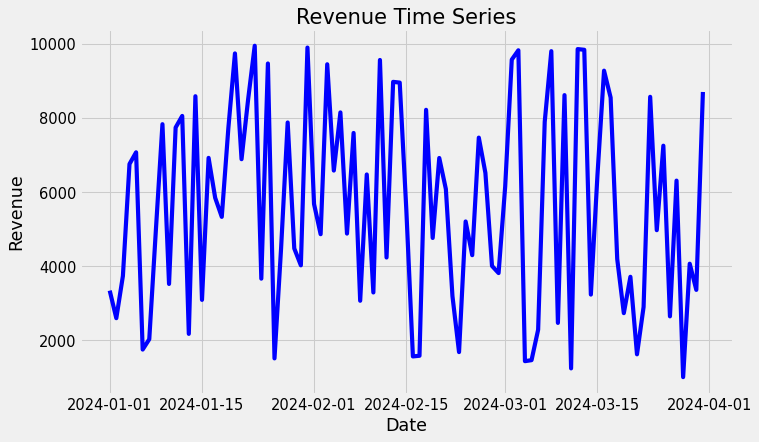

In [5]:
def plot_time_series(dates, revenues, title='Revenue Time Series', xlabel='Date', ylabel='Revenue'):
    plt.plot(dates, revenues, color='blue', linestyle='solid')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_time_series(dates, revenues)

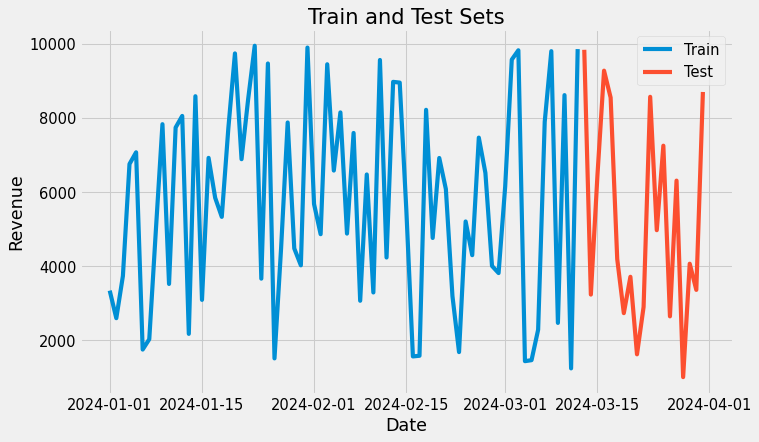

In [6]:
def visualize_train_test(train_dates, train_revenues, test_dates, test_revenues):
    plt.plot(train_dates, train_revenues, label='Train')
    plt.plot(test_dates, test_revenues, label='Test')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.title('Train and Test Sets')
    plt.legend()
    plt.show()


visualize_train_test(train_dates, train_revenues, test_dates, test_revenues)

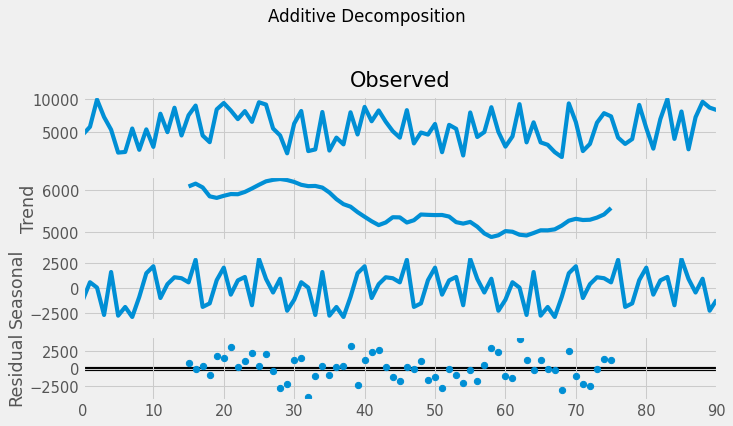

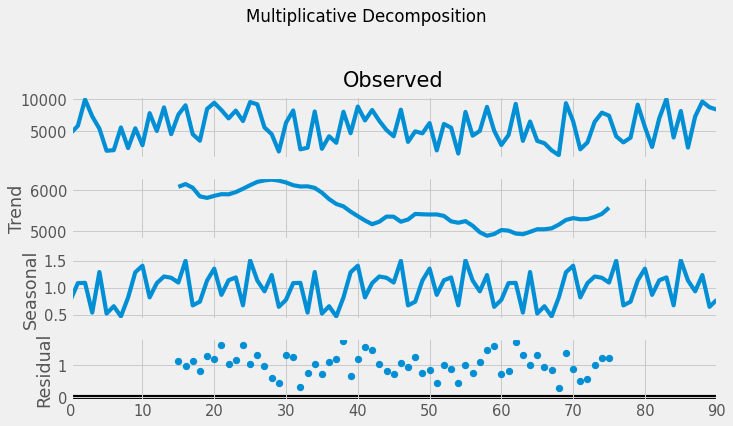

In [126]:
def seasonal_decompose(dates, revenues):
    
    multiplicative_decomposition = sm.tsa.seasonal_decompose(revenues, model='multiplicative', period=30)
    additive_decomposition = sm.tsa.seasonal_decompose(revenues, model='additive', period=30) 
    
    additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

seasonal_decompose(dates, revenues)

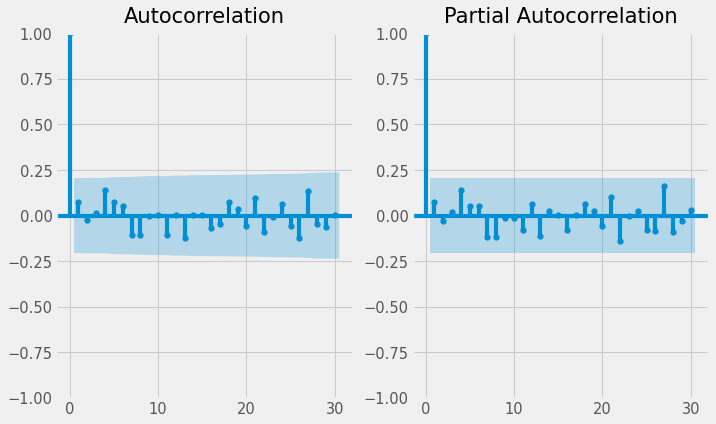

In [127]:
def acf_pacf(dates, revenues):
    fig, ax = plt.subplots(1, 2)
    sm.graphics.tsa.plot_acf(revenues, lags=30, ax=ax[0])
    sm.graphics.tsa.plot_pacf(revenues, lags=30, ax=ax[1])
    plt.show()
    
acf_pacf(dates, revenues)

In [128]:
def stationarity_test(dates, revenues):
    adf, pval, usedlag, nobs, crit_vals, icbest = sm.tsa.stattools.adfuller(revenues)
    print('ADF test statistic:', adf)
    print('ADF p-values:', pval)
    
    if pval < 0.05:
        print('-----Reject null hypothesis (non-stationarity), accept alternative hypothesis (data is stationary)-----')
    else:
        # Difference the data
        diff_revenues = numpy.diff(revenues)
        adf_diff, pval_diff, usedlag_diff, nobs_diff, crit_vals_diff, icbest_diff = sm.tsa.stattools.adfuller(diff_revenues)
        print('ADF test statistic after differencing:', adf_diff)
        print('ADF p-values after differencing:', pval_diff)
        
        if pval_diff < 0.05:
            print('-----Reject null hypothesis after differencing (non-stationarity), accept alternative hypothesis (data is stationary)-----')
        else:
            # Detrend the data
            detrend_revenues = sm.tsa.detrend(revenues)
            adf_detrend, pval_detrend, usedlag_detrend, nobs_detrend, crit_vals_detrend, icbest_detrend = sm.tsa.stattools.adfuller(detrend_revenues)
            print('ADF test statistic after detrending:', adf_detrend)
            print('ADF p-values after detrending:', pval_detrend)
            
            if pval_detrend < 0.05:
                print('-----Reject null hypothesis after detrending (non-stationarity), accept alternative hypothesis (data is stationary)-----')
            else:
                # Deseasonalize the data
                seasonal_decompose = sm.tsa.seasonal_decompose(revenues, model='multiplicative', period=30)
                deseasonal_revenues = revenues / seasonal_decompose.seasonal
                adf_deseasonal, pval_deseasonal, usedlag_deseasonal, nobs_deseasonal, crit_vals_deseasonal, icbest_deseasonal = sm.tsa.stattools.adfuller(deseasonal_revenues)
                print('ADF test statistic after deseasonalizing:', adf_deseasonal)
                print('ADF p-values after deseasonalizing:', pval_deseasonal)
                
                if pval_deseasonal < 0.05:
                    print('-----Reject null hypothesis after deseasonalizing (non-stationarity), accept alternative hypothesis (data is stationary)-----')
                else:
                    print('-----Fail to reject null hypothesis (non-stationarity) after all transformations-----')
    
    print('ADF number of lags used:', usedlag)
    print('ADF number of observations:', nobs)
    print('ADF critical values:', crit_vals)
    print('ADF best information criterion:', icbest)

stationarity_test(dates, revenues)

ADF test statistic: -8.647071979083487
ADF p-values: 5.235678373934295e-14
-----Reject null hypothesis (non-stationarity), accept alternative hypothesis (data is stationary)-----
ADF number of lags used: 0
ADF number of observations: 90
ADF critical values: {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}
ADF best information criterion: 1443.9513401430436


In [9]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def auto_arima(train_dates, train_revenues, test_dates, test_revenues):
    # Fit ARIMA model
    model = sm.tsa.ARIMA(train_revenues, order=(2, 1, 2))
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=len(test_revenues))
    
    # Plot actual, forecast, and test values
    plt.plot(train_dates, train_revenues, label='Train')
    plt.plot(test_dates, test_revenues, label='Test')
    plt.plot(test_dates, forecast, label='Forecast')
    plt.legend()
    plt.show()

    # Calculate metrics
    mae = mean_absolute_error(test_revenues, forecast)
    mse = mean_squared_error(test_revenues, forecast)
    rmse = mean_squared_error(test_revenues, forecast, squared=False)

    # Print metrics
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)

auto_arima(train_dates, train_revenues, test_dates, test_revenues)


ValueError: too many values to unpack (expected 3)

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


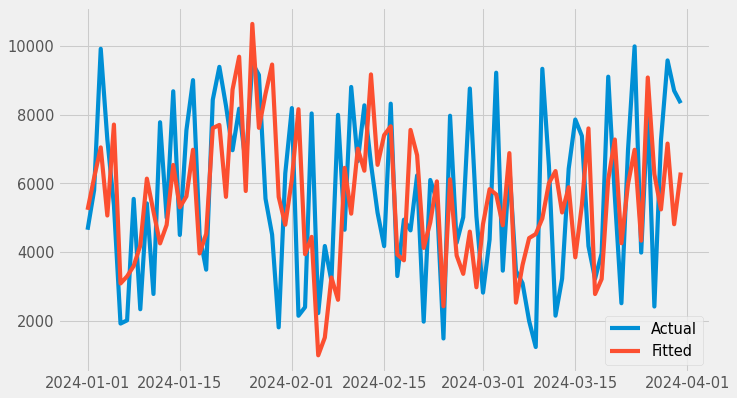

MAE: 1951.0474468790035
MSE: 5427053.732220656
RMSE: 2329.6037715072184


In [130]:
def simple_expoential_smoothing(dates, revenues):
    model = sm.tsa.ExponentialSmoothing(revenues, trend='add', seasonal='add', seasonal_periods=30)
    model.fit(smoothing_level=0.2, smoothing_trend=0.2, smoothing_seasonal=0.2)
    
    # Predict values
    preds = model.predict(model.params, start=0, end=None)
    
    # Plot actual and predicted values
    plt.plot(dates, revenues, label='Actual')
    plt.plot(dates, preds, label='Fitted')
    plt.legend()
    plt.show()
    
    # Calculate metrics
    mae = mean_absolute_error(revenues, preds)
    mse = mean_squared_error(revenues, preds)
    rmse = mean_squared_error(revenues, preds, squared=False)
    
    # Print metrics
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    
simple_expoential_smoothing(dates, revenues)

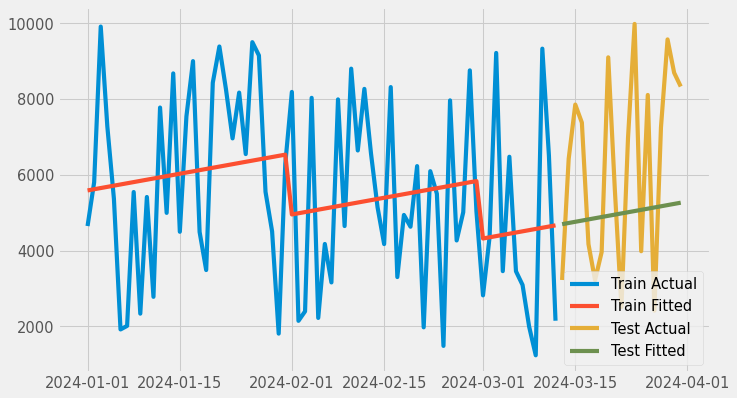

Train MAE: 1997.3966632365243
Train MSE: 5588284.830410104
Train RMSE: 2363.9553359592273
Test MAE: 2424.929134374866
Test MSE: 7367173.207817846
Test RMSE: 2714.2537110258954


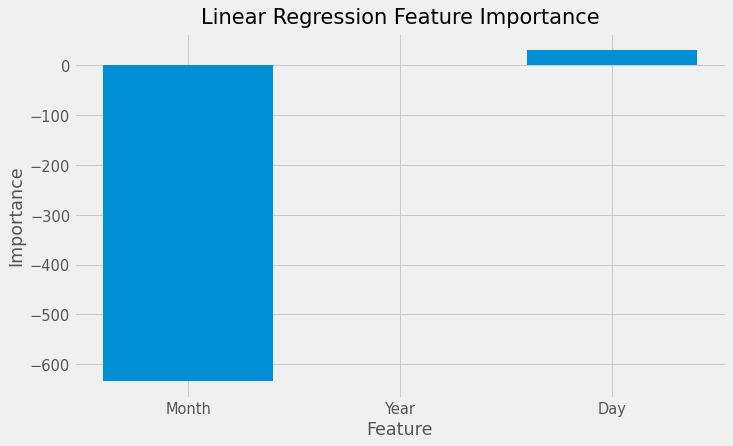

In [134]:
def linear_regression(train_dates, train_revenues, test_dates, test_revenues):
    from sklearn.linear_model import LinearRegression
    months_train = [d.month for d in train_dates]
    years_train = [d.year for d in train_dates]
    day_train = [d.day for d in train_dates]
    x_train = numpy.array([months_train, years_train, day_train]).T
    y_train = numpy.array(train_revenues)
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    months_test = [d.month for d in test_dates]
    years_test = [d.year for d in test_dates]
    day_test = [d.day for d in test_dates]
    x_test = numpy.array([months_test, years_test, day_test]).T
    y_test = numpy.array(test_revenues)
    
    preds_train = model.predict(x_train)
    preds_test = model.predict(x_test)
    
    plt.plot(train_dates, train_revenues, label='Train Actual')
    plt.plot(train_dates, preds_train, label='Train Fitted')
    plt.plot(test_dates, test_revenues, label='Test Actual')
    plt.plot(test_dates, preds_test, label='Test Fitted')
    plt.legend()
    plt.show()
    
    mae_train = mean_absolute_error(train_revenues, preds_train)
    mse_train = mean_squared_error(train_revenues, preds_train)
    rmse_train = mean_squared_error(train_revenues, preds_train, squared=False)
    
    mae_test = mean_absolute_error(test_revenues, preds_test)
    mse_test = mean_squared_error(test_revenues, preds_test)
    rmse_test = mean_squared_error(test_revenues, preds_test, squared=False)
    
    print("Train MAE:", mae_train)
    print("Train MSE:", mse_train)
    print("Train RMSE:", rmse_train)
    
    print("Test MAE:", mae_test)
    print("Test MSE:", mse_test)
    print("Test RMSE:", rmse_test)
    
    # Plot feature importance
    feature_names = ['Month', 'Year', 'Day']
    feature_importance = model.coef_
    plt.bar(feature_names, feature_importance)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Linear Regression Feature Importance')
    plt.show()
    
linear_regression(train_dates, train_revenues, test_dates, test_revenues)


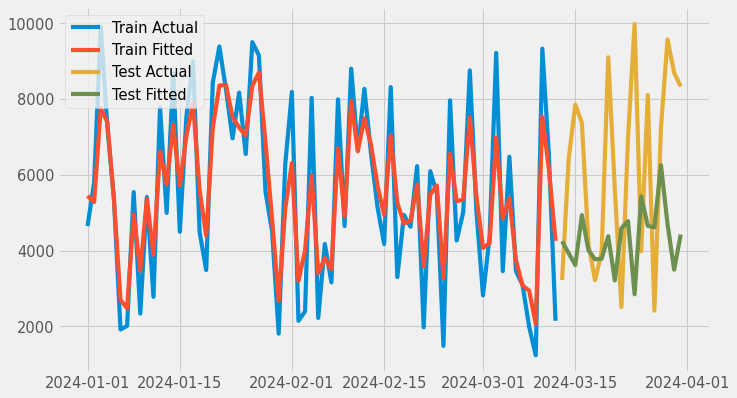

Train MAE: 886.7441666666667
Train MSE: 1117341.2311
Train RMSE: 1057.0436278129678
Test MAE: 2720.468421052631
Test MSE: 10820694.646494735
Test RMSE: 3289.482428360841


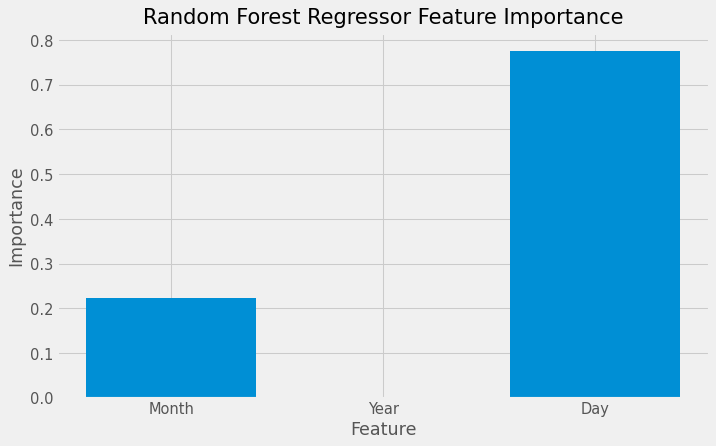

In [135]:
def random_forest_regressor(train_dates, train_revenues, test_dates, test_revenues):
    from sklearn.ensemble import RandomForestRegressor
    
    months_train = [d.month for d in train_dates]
    years_train = [d.year for d in train_dates]
    day_train = [d.day for d in train_dates]
    x_train = numpy.array([months_train, years_train, day_train]).T
    y_train = numpy.array(train_revenues)
    
    model = RandomForestRegressor()
    model.fit(x_train, y_train)
    
    months_test = [d.month for d in test_dates]
    years_test = [d.year for d in test_dates]
    day_test = [d.day for d in test_dates]
    x_test = numpy.array([months_test, years_test, day_test]).T
    y_test = numpy.array(test_revenues)
    
    preds_train = model.predict(x_train)
    preds_test = model.predict(x_test)
    
    plt.plot(train_dates, train_revenues, label='Train Actual')
    plt.plot(train_dates, preds_train, label='Train Fitted')
    plt.plot(test_dates, test_revenues, label='Test Actual')
    plt.plot(test_dates, preds_test, label='Test Fitted')
    plt.legend()
    plt.show()
    
    mae_train = mean_absolute_error(train_revenues, preds_train)
    mse_train = mean_squared_error(train_revenues, preds_train)
    rmse_train = mean_squared_error(train_revenues, preds_train, squared=False)
    
    mae_test = mean_absolute_error(test_revenues, preds_test)
    mse_test = mean_squared_error(test_revenues, preds_test)
    rmse_test = mean_squared_error(test_revenues, preds_test, squared=False)
    
    print("Train MAE:", mae_train)
    print("Train MSE:", mse_train)
    print("Train RMSE:", rmse_train)
    
    print("Test MAE:", mae_test)
    print("Test MSE:", mse_test)
    print("Test RMSE:", rmse_test)
    
    # Plot feature importance
    feature_names = ['Month', 'Year', 'Day']
    feature_importance = model.feature_importances_
    plt.bar(feature_names, feature_importance)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Random Forest Regressor Feature Importance')
    plt.show()

random_forest_regressor(train_dates, train_revenues, test_dates, test_revenues)


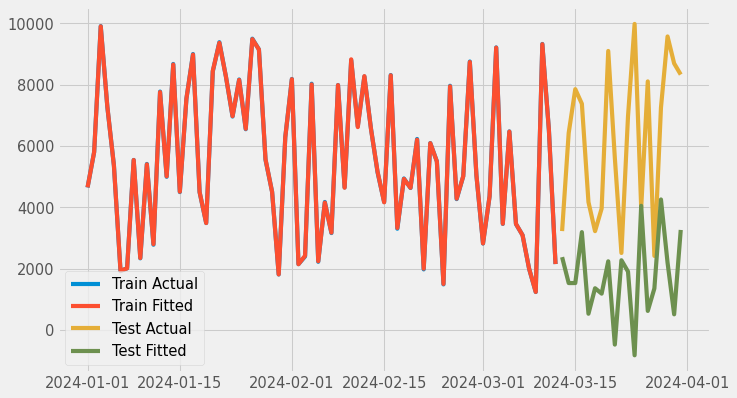

Train MAE: 10.849424574110243
Train MSE: 173.62900993786752
Train RMSE: 13.17683611258285
Test MAE: 4518.413546913548
Test MSE: 28776716.387283996
Test RMSE: 5364.393384837096


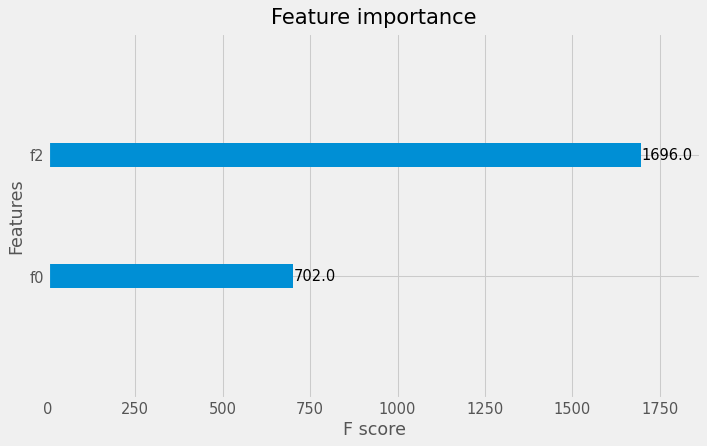

In [136]:
def xg_boost(train_dates, train_revenues, test_dates, test_revenues):
    import xgboost as xgb
        
    months_train = [d.month for d in train_dates]
    years_train = [d.year for d in train_dates]
    day_train = [d.day for d in train_dates]
    x_train = numpy.array([months_train, years_train, day_train]).T
    y_train = numpy.array(train_revenues)
    
    model = xgb.XGBRegressor()
    model.fit(x_train, y_train)
    
    months_test = [d.month for d in test_dates]
    years_test = [d.year for d in test_dates]
    day_test = [d.day for d in test_dates]
    x_test = numpy.array([months_test, years_test, day_test]).T
    y_test = numpy.array(test_revenues)
    
    preds_train = model.predict(x_train)
    preds_test = model.predict(x_test)
    
    plt.plot(train_dates, train_revenues, label='Train Actual')
    plt.plot(train_dates, preds_train, label='Train Fitted')
    plt.plot(test_dates, test_revenues, label='Test Actual')
    plt.plot(test_dates, preds_test, label='Test Fitted')
    plt.legend()
    plt.show()
    
    mae_train = mean_absolute_error(train_revenues, preds_train)
    mse_train = mean_squared_error(train_revenues, preds_train)
    rmse_train = mean_squared_error(train_revenues, preds_train, squared=False)
    
    mae_test = mean_absolute_error(test_revenues, preds_test)
    mse_test = mean_squared_error(test_revenues, preds_test)
    rmse_test = mean_squared_error(test_revenues, preds_test, squared=False)
    
    print("Train MAE:", mae_train)
    print("Train MSE:", mse_train)
    print("Train RMSE:", rmse_train)
    
    print("Test MAE:", mae_test)
    print("Test MSE:", mse_test)
    print("Test RMSE:", rmse_test)
    
    # Plot feature importance
    xgb.plot_importance(model)
    plt.show()

train_dates, train_revenues, test_dates, test_revenues = train_and_test_sets_generation(dates, revenues)
xg_boost(train_dates, train_revenues, test_dates, test_revenues)


Multivariate Forecasting

In [176]:
import pandas as pd
from datetime import datetime, timedelta
import random

def generate_multivariate_time_series_data(start_date, end_date):
    """Generates time series data using specified start_date and end_date.

    Args:
        start_date (datetime): The start date of the time series.
        end_date (datetime): The end date of the time series.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the date, revenue, LOB, unit, flag, and flag_description.
    """
    data = []
    current_date = start_date

    while current_date <= end_date:
        value = random.randint(1000, 10000)
        lob = random.choice(['A', 'B', 'C'])
        unit = random.choice(['Unit1', 'Unit2', 'Unit3'])
        flag = random.choice(['DD', 'EE', 'FF'])
        flag_description = random.choice(['Official Figure', 'Unofficial Figure', 'Mandate'])
        data.append((current_date, value, lob, unit, flag, flag_description))
        current_date += timedelta(days=1)

    columns = ['Date', 'Value', 'LOB', 'Unit', 'Flag', 'Flag_Description']
    df = pd.DataFrame(data, columns=columns)
    return df

data = generate_multivariate_time_series_data(datetime(2024, 1, 1), datetime(2024, 3, 31))
data

# Split the data into train and test sets
train_size = int(len(data) * 0.8)  # 80% for training
multivariate_train_data = data[:train_size]
multivariate_test_data = data[train_size:]

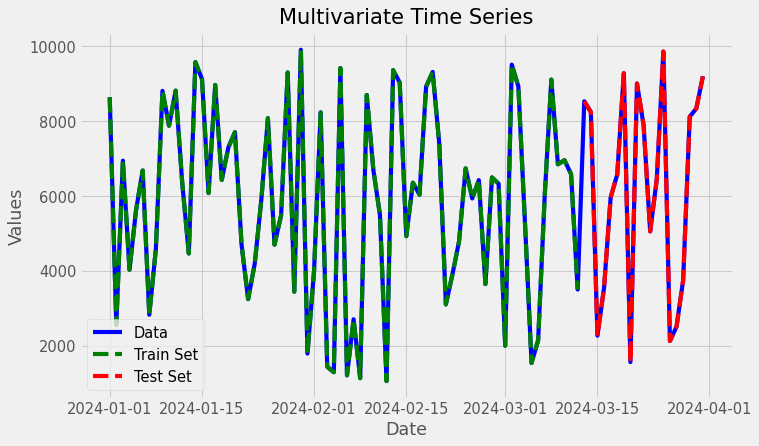

In [177]:
def plot_time_series(data, train_data=None, test_data=None, x_key='Date', y_key='Value', title='Multivariate Time Series', xlabel='Date', ylabel='Values'):
    x = data[x_key]
    y = data[y_key]
    plt.plot(x, y, color='blue', linestyle='solid', label='Data')
    
    if train_data is not None:
        train_x = train_data[x_key]
        train_y = train_data[y_key]
        plt.plot(train_x, train_y, color='green', linestyle='dashed', label='Train Set')
    
    if test_data is not None:
        test_x = test_data[x_key]
        test_y = test_data[y_key]
        plt.plot(test_x, test_y, color='red', linestyle='dashed', label='Test Set')
    
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.legend()
    plt.show()


plot_time_series(data, train_data=multivariate_train_data,
                 test_data=multivariate_test_data)

C:\Users\josep\AppData\Local\Temp\ipykernel_7844\4079238580.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i] = model.predict([x_])
C:\Users\josep\AppData\Local\Temp\ipykernel_7844\4079238580.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i] = model.predict([x_])
C:\Users\josep\AppData\Local\Temp\ipykernel_7844\4079238580.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i] = model.predict([x_])
C:\Users\josep\AppData\Local\Temp\ipykernel_7844\

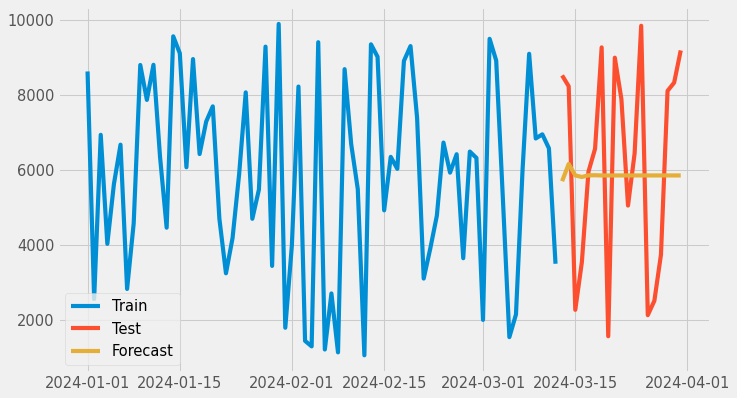

In [182]:
def autoregressive(lag = 3):
    x = list()
    y = list()
    for i in range(lag, len(multivariate_train_data)):
        x.append(multivariate_train_data['Value'].iloc[i-lag:i].values)
        y.append(multivariate_train_data['Value'].iloc[i])
    
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x, y)
    
    p = numpy.zeros(len(multivariate_test_data))
    x_ = multivariate_train_data['Value'].iloc[-lag:].values
    for i in range(len(multivariate_test_data)):
        p[i] = model.predict([x_])
        x_ = numpy.roll(x_, -1)
        x_[-1] = p[i] 
    plt.plot(multivariate_train_data['Date'], multivariate_train_data['Value'], label='Train')
    plt.plot(multivariate_test_data['Date'], multivariate_test_data['Value'], label='Test')
    plt.plot(multivariate_test_data['Date'], p, label='Forecast')
    plt.legend()
    plt.show()
    

autoregressive()